1. Tải các thư viện cần thiết thông qua File Requiment.txt

In [ ]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib


2. Import thư viện cần thiết cho việc nhận diện

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from keras.models import load_model

3. Tạo biến lưu các điểm trên khuôn mặt và các điểm mốc trên cơ thể

In [3]:
mp_holistic = mp.solutions.holistic # Mô hình holistic
mp_drawing = mp.solutions.drawing_utils # Vẽ các điểm đánh dấu

4. Tạo hàm tiền xử lý hình ảnh

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

5. Tạo hàm vẽ các điểm trên bàn tay và khuôn mặt

In [5]:

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections


6. Tạo hàm vẽ điểm mốc trên cơ thể

In [6]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

7. Thực hiện nhận diện cử chỉ của khuôn mặt và cơ thể thông qua thư viện OpenCV

In [ ]:
cap = cv2.VideoCapture(0)
# # Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
   while cap.isOpened():

      # Read feed
    ret, frame = cap.read()

#         # Make detections
    image, results = mediapipe_detection(frame, holistic)
    print(results)
        
#         # Draw landmarks
    draw_styled_landmarks(image, results)

#         # Show to screen
    cv2.imshow('OpenCV Feed', image)

#         # Break when type 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

8. Lưu các điểm mốc thành mảng

In [8]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

9. Đọc dữ liệu từ File nếu chưa có thì sẽ tạo File Data

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Data') 

# Actions that we try to detect
actions = np.array(['Xin_chao','Xin_loi','Cam_on','Tam_biet','Hay_lien_he_voi_toi_mot_cach_an_toan', 'Rat_vui_duoc_gap_ban','Me','Cha','Lai_lan_nua','An','Them_nua','Ngu','Tam'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 60 frames in length
sequence_length = 60

10. Hàm thực hiện ghi các khung hình để tạo dữ liệu

In [105]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [106]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
                    
cap.release()
cv2.destroyAllWindows()

11. Import thư viện để train model

In [10]:
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

11. Tạo mảng để lưu các hành động ở trên

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

12. Gán nhãn các hành động

In [13]:
sequences, labels = [], [] #gán nhãn
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:

print(actions.shape[0])

13


In [16]:
np.array(sequences).shape

(390, 60, 126)

In [17]:
np.array(labels).shape

(390,)

In [18]:
X = np.array(sequences)

In [19]:
X.shape

(390, 60, 126)

In [20]:
y = to_categorical(labels).astype(int)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #chia test

13. Import thư viện Keras và TensorFLow để train Model

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
import tensorflow as tf

14. Tạo File Logs và ghi lại lịch sử sự kiện

In [22]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

15. Quy định các khung hình của lớp LSTM và Dense

In [23]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,126))) # 64
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [24]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

16. Quy định số lần Epochs của mô hình và Train Model

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [ ]:
model.summary()

17. Lưu mô hình về dạng h5

In [150]:
model.save('13.h5')

c:\Users\heoti\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18. Chạy lại Model

In [25]:
model.load_weights('13.h5')

19. Đánh giá model

In [26]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [38]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(ytrue, yhat)
print('Confusion matrix:')
print(cnf_matrix)

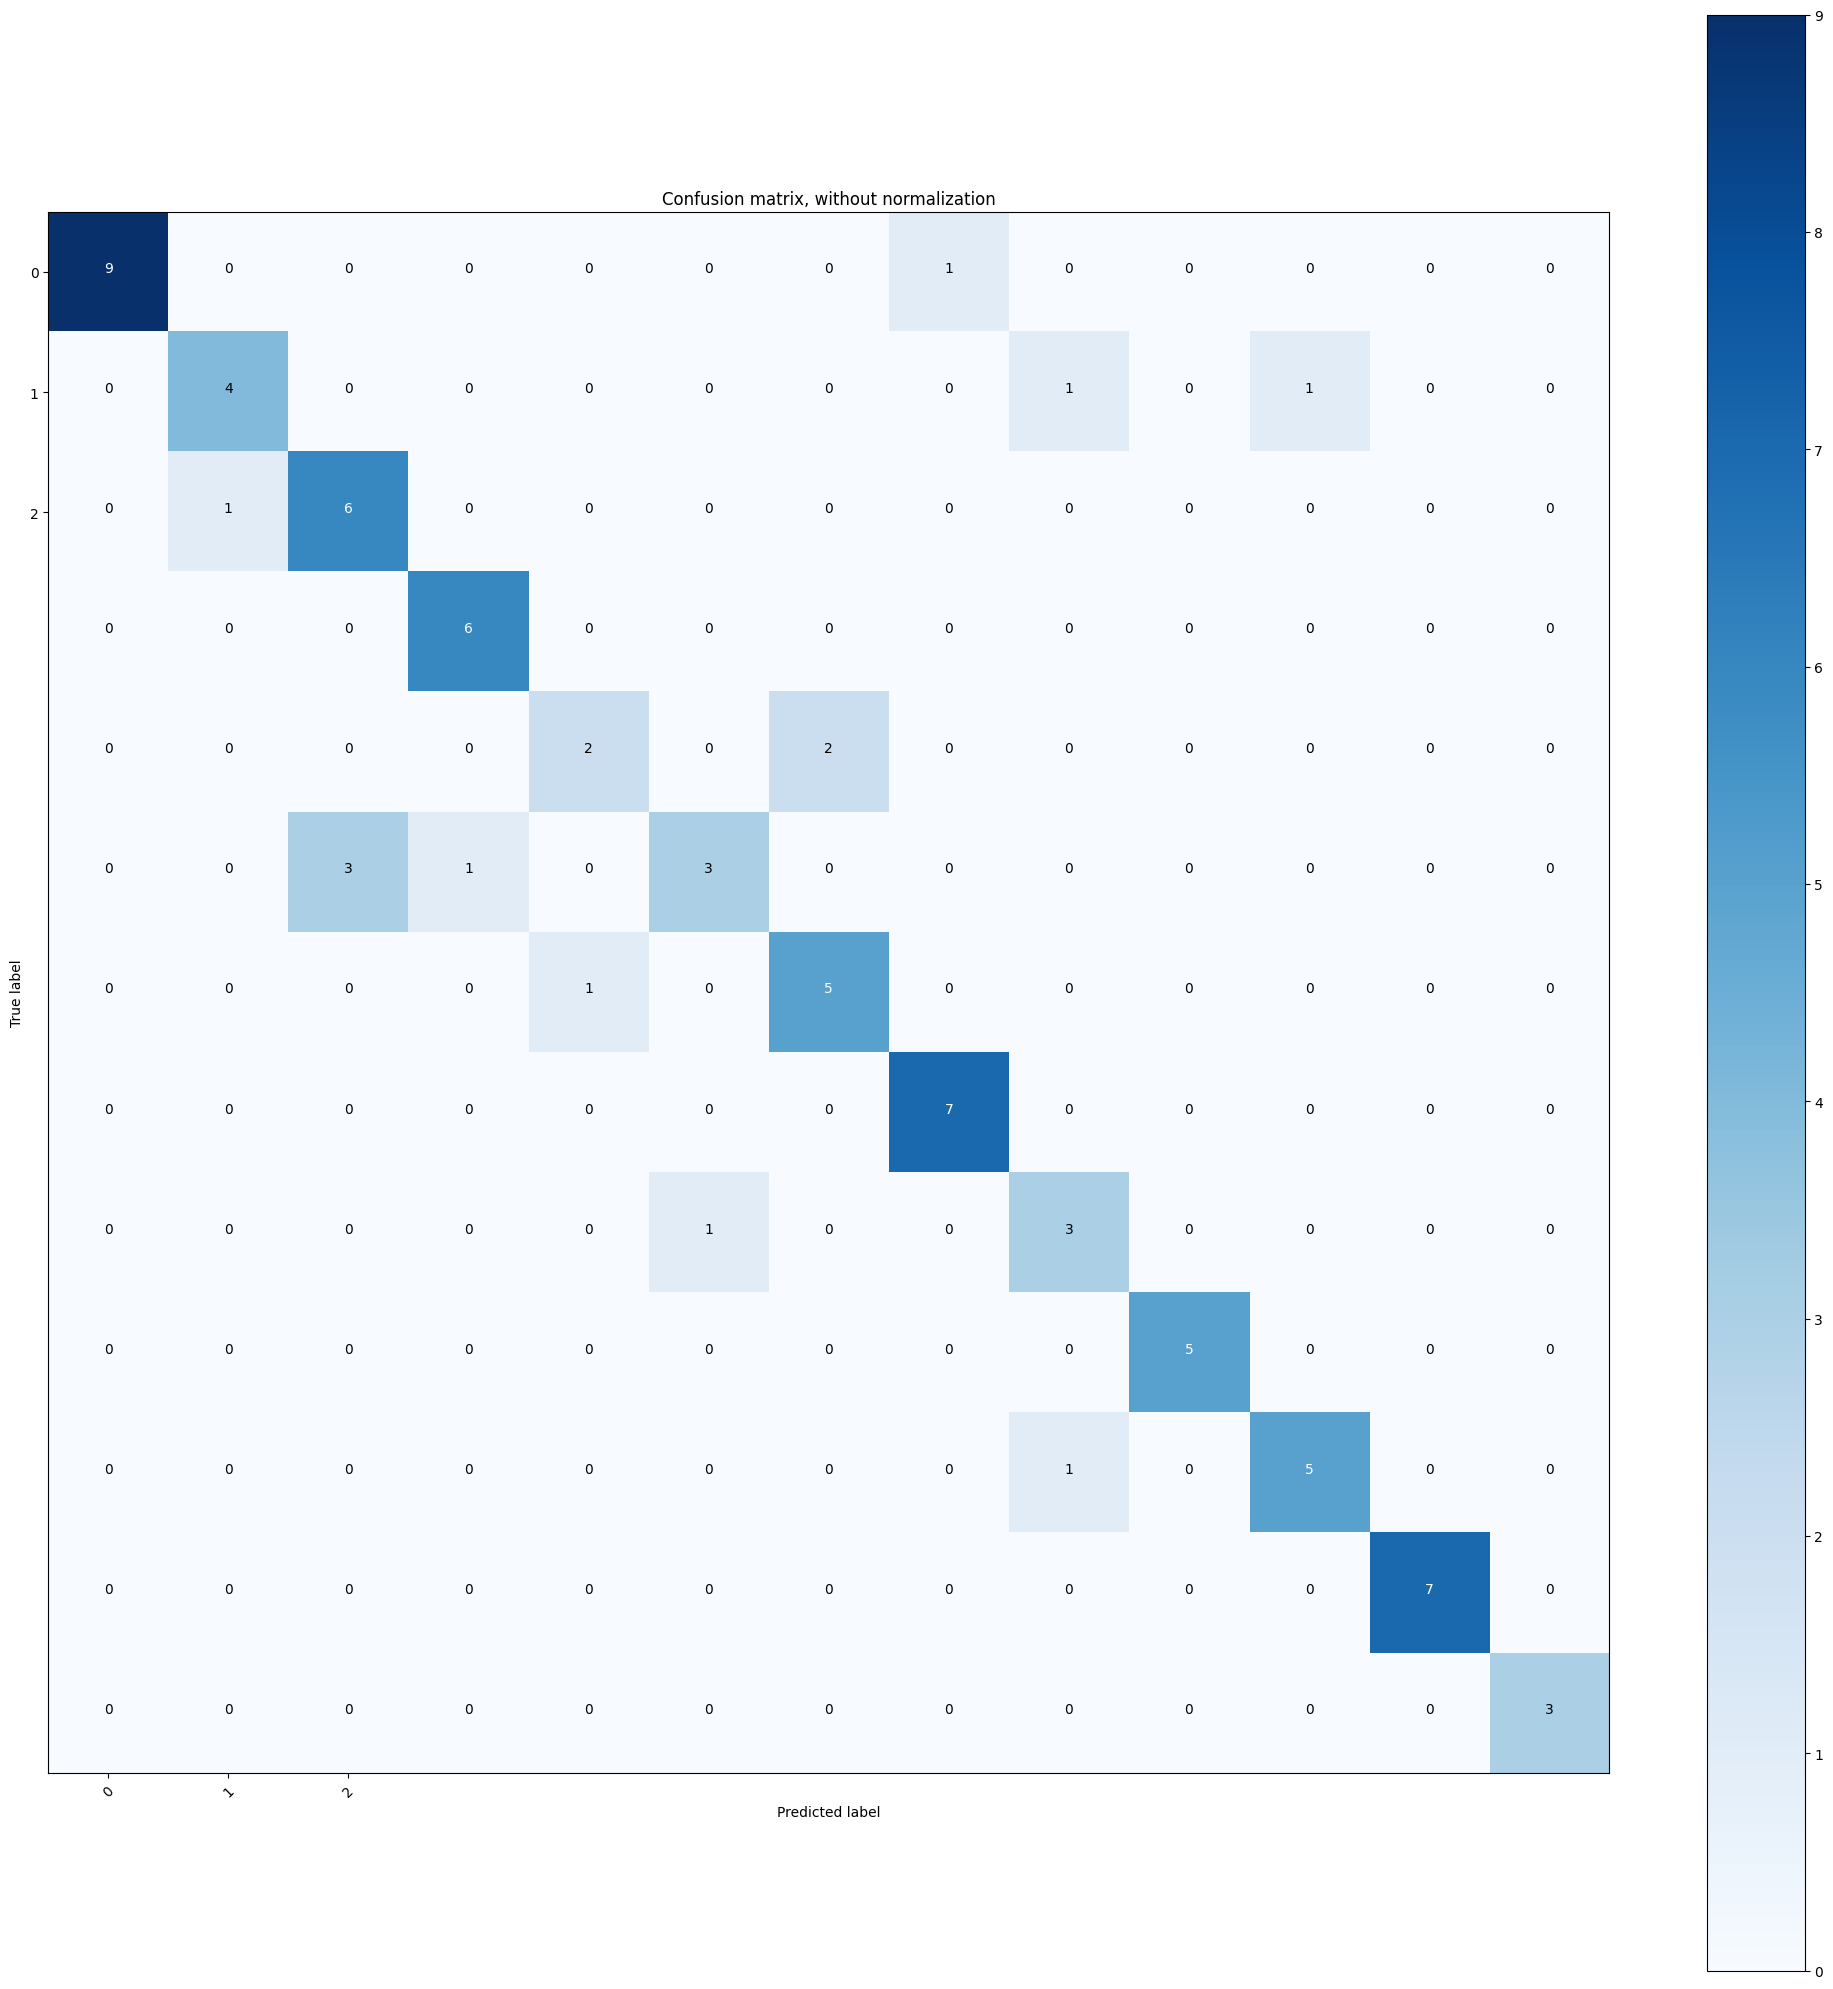

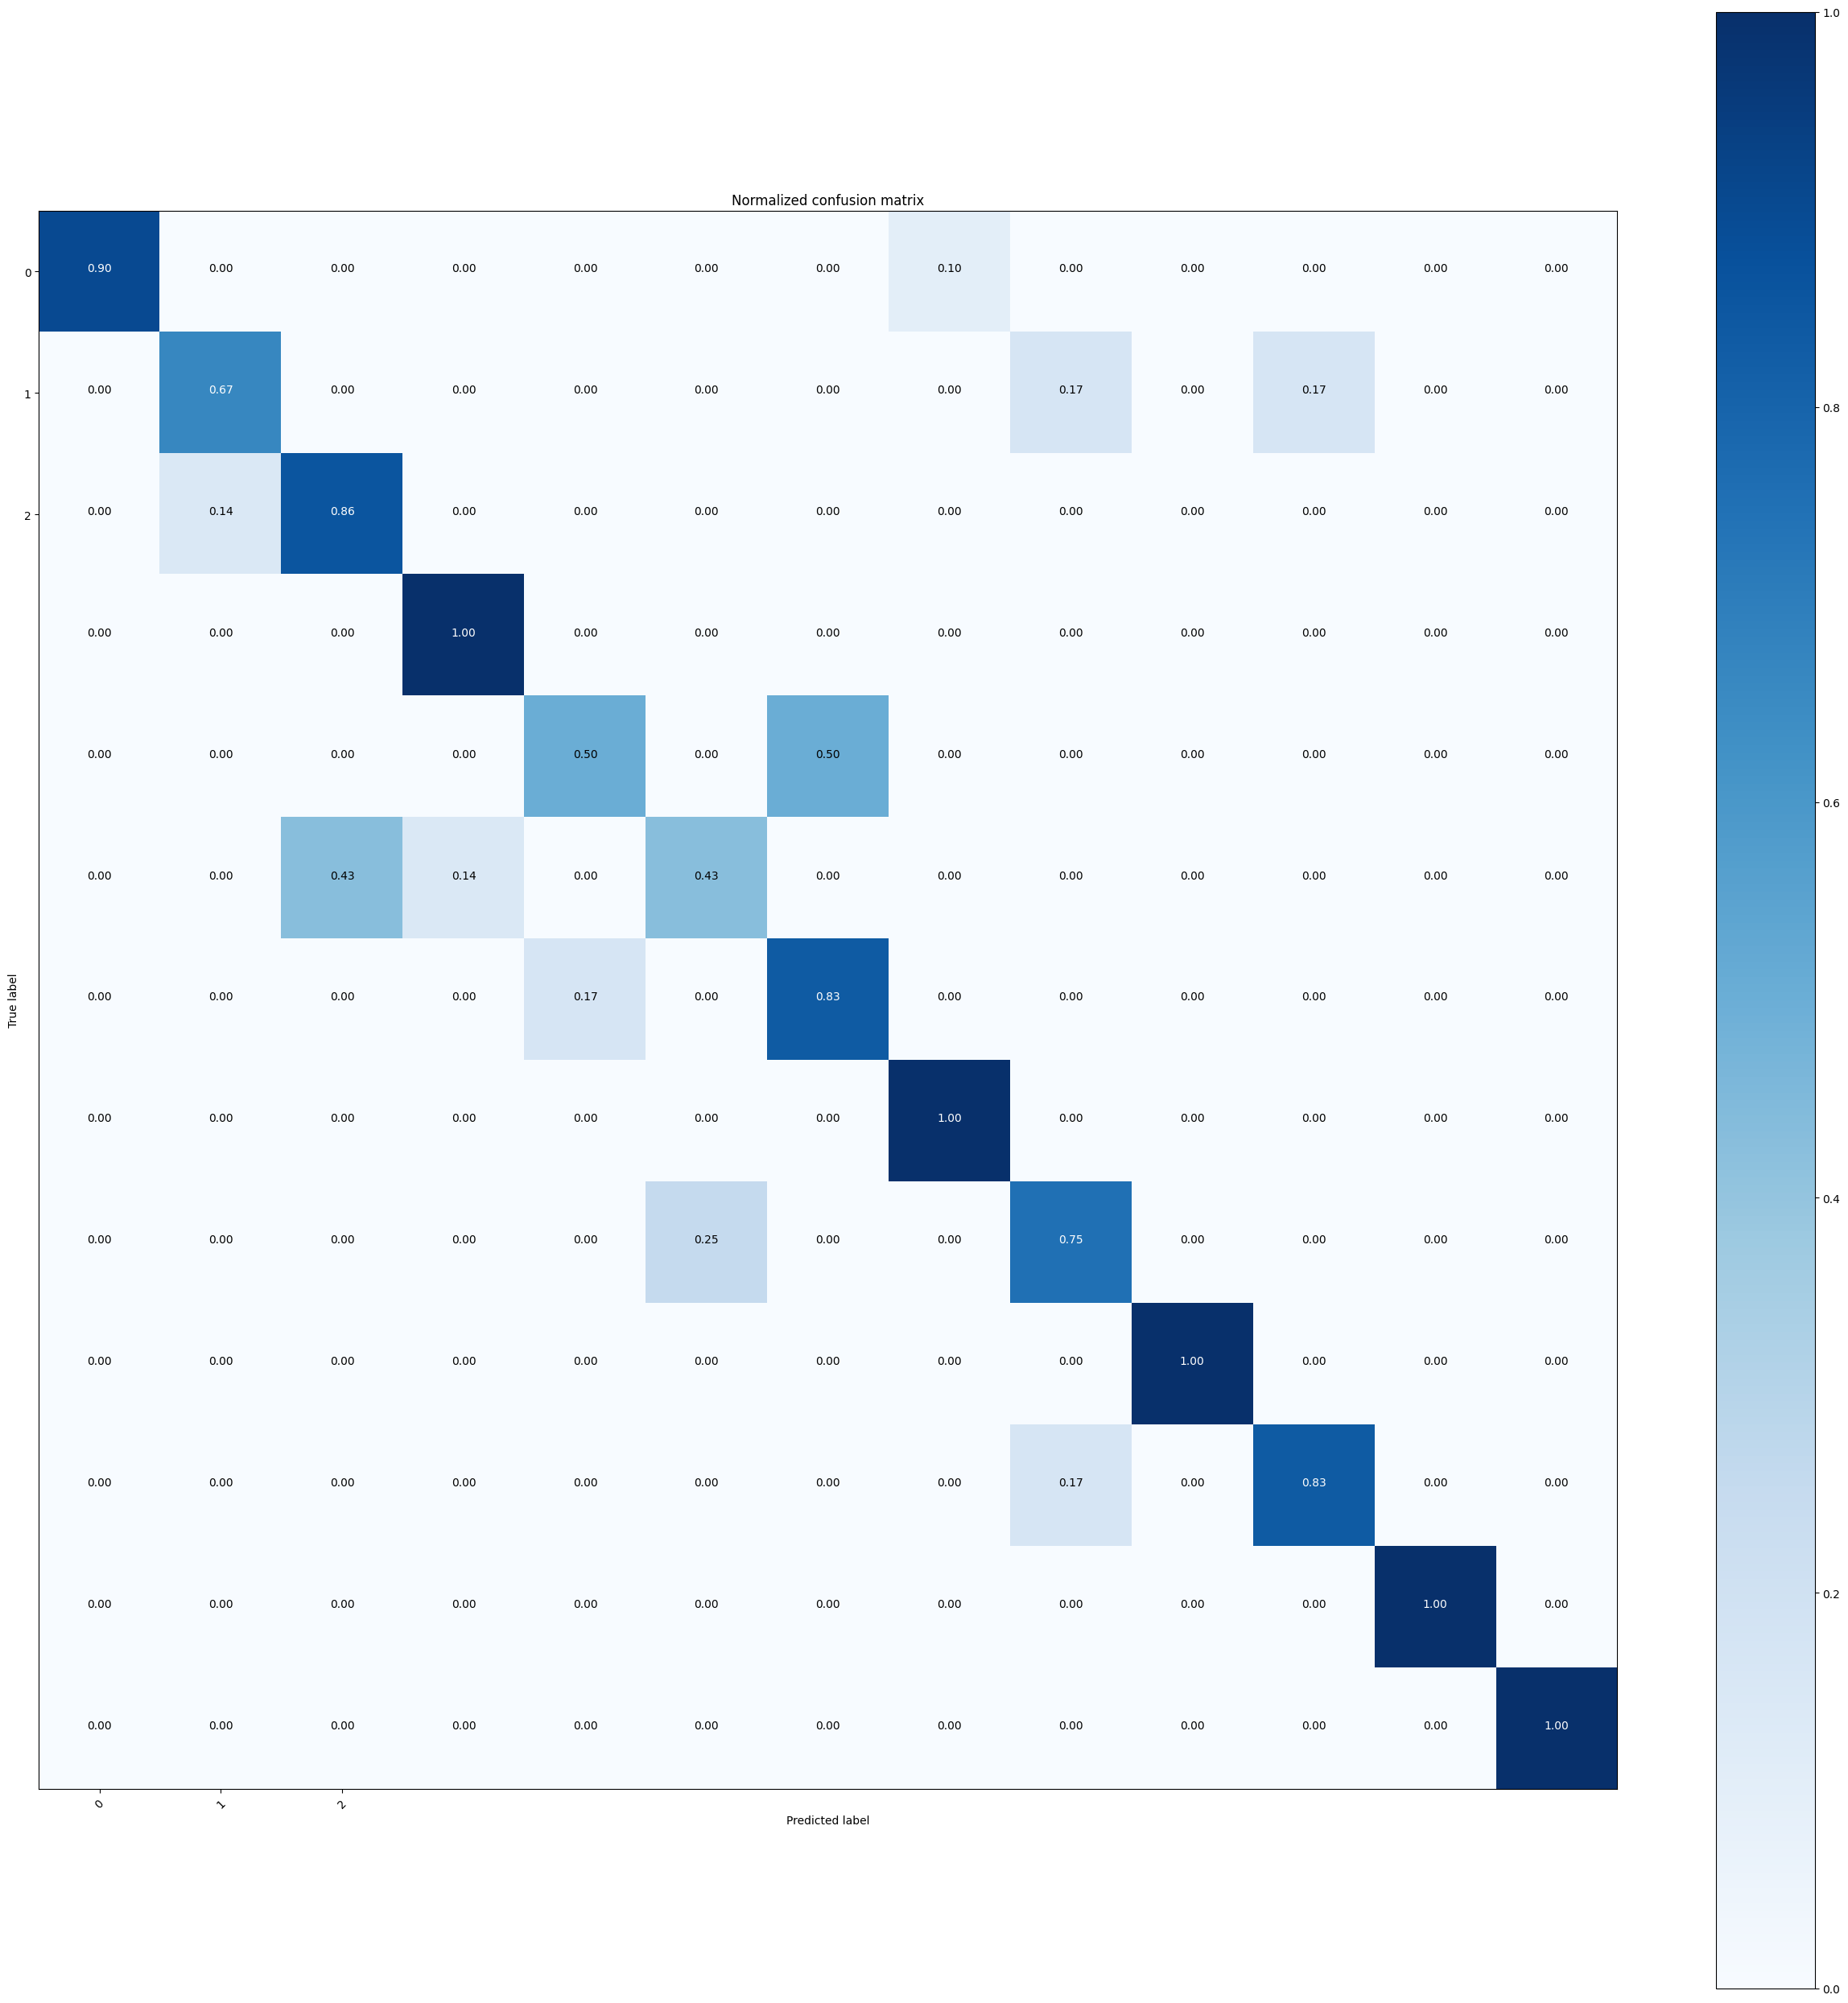

In [157]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2]
plt.figure(figsize = (20, 20))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize = (25, 25))
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [28]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [29]:
import time

In [ ]:

plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [58]:
sequence.reverse()

In [57]:
len(sequence)

61

In [56]:
sequence.append('def')

In [54]:
sequence.reverse()

In [ ]:
sequence[-30:]

20. Chạy model nhận diện ngôn ngữ ký hiệu

In [ ]:
import cv2   
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0) 
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() # đọc video từ camera

        # Make detections
        image, results = mediapipe_detection(frame, holistic) # gọi biến image và result = giá trị RGB của ảnh
        print(results)
        
        # Draw landmarks
       # nhận diện cơ thể 
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results) # xuất ra array các keypoints cơ thể (mấy cái đốt í)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-60:] # Đưa các frame thu đc vào mảng sequence, ở đây t để là 30 frame cuối
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)]) # Nếu thu đủ số frame của câu, đưa các array đấy vào model rồi ước lượng ra kết quả chính xác nhất trong dữ liệu
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 0: 
                sentence = sentence[-1:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        # Show to screen
        cv2.imshow('NHAN DANG NGON NGU KY HIEU', image)
        

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
model.summary()

In [161]:
res[np.argmax(res)] > threshold

True

In [43]:
from sklearn.metrics import accuracy_score




In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))

21. Lưu model về dạng TensorFlowlite để chạy trên các nền tảng thấp

In [81]:
import tensorflow as tf
keras_model = load_model ('begin.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
# converter.optimizations = [tf.lite.Optimize.DEFAULT] # sử dụng optimization nếu cần tối ưu thêm
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\heoti\AppData\Local\Temp\tmplrhkxvaw\assets


INFO:tensorflow:Assets written to: C:\Users\heoti\AppData\Local\Temp\tmplrhkxvaw\assets
